## install library yang dibutuhkan

In [1]:
!pip install Sastrawi -q
!pip install torch -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 14.2 MB/s eta 0:00:00


## import library

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tqdm.auto import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
# Remove AdamW from transformers import
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from torch.utils.data import DataLoader, Dataset
from google.colab import drive
# Import AdamW from torch.optim
from torch.optim import AdamW

## Load dan Read Dataset

In [3]:
data = pd.read_csv('/content/dataset.csv')
data.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1953709921956245741,Fri Aug 08 06:48:38 +0000 2025,0,Kebijakan makan bergizi gratis dari Presiden P...,1953709921956245741,https://pbs.twimg.com/media/Gxz4v8tacAA6oCf.jpg,NaN,in,NaN,0,0,0,https://x.com/undefined/status/195370992195624...,1709081066882076672,NaN
1,1946196341438226645,Fri Jul 18 14:20:44 +0000 2025,54,@diraku__14 @nabiylarisfa @prabowo Makanan Ber...,1946213552215249266,NaN,diraku__14,in,NaN,0,0,0,https://x.com/undefined/status/194621355221524...,86733183,NaN
2,1929402598076924126,Wed Jun 04 02:19:20 +0000 2025,0,@Selaksantai @ARSIPAJA @MakeItAQuote @pikaso_m...,1930086939207840107,NaN,Selaksantai,in,NaN,0,1,0,https://x.com/undefined/status/193008693920784...,1720665183188922368,NaN
3,1910606509853336037,Sat Apr 12 08:32:40 +0000 2025,0,@MasterFiqri @WahyuDj99 @La21921Lalane @hniran...,1910974337852850557,https://pbs.twimg.com/media/GnglrEPaIAA-yGm.jpg,MasterFiqri,in,NaN,0,0,0,https://x.com/undefined/status/191097433785285...,1720665183188922368,NaN
4,1910888007546327167,Sat Apr 12 03:17:37 +0000 2025,1,@oxnewbie @Strategi_Bisnis Tarif Trump merugik...,1910895050747515119,NaN,oxnewbie,in,NaN,0,0,0,https://x.com/undefined/status/191089505074751...,1720665183188922368,NaN


## prepoccessing data

In [4]:
data['full_text'] = data['full_text'].str.lower()

In [5]:
import pandas as pd
import re

# Load the CSV file
file_path = '/content/dataset.csv'
df = pd.read_csv(file_path)

# Load the Excel file containing the normalization dictionary
normalization_file_path = '/content/text.xlsx'
normalization_df = pd.read_excel(normalization_file_path)

# Convert the normalization dataframe to a dictionary
normalization_dict = pd.Series(normalization_df.formal.values, index=normalization_df.slang).to_dict()

# Function to clean and normalize text using the normalization dictionary
def clean_and_normalize_text(text, normalization_dict):
    if pd.isna(text):
        return ''
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove emojis and special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove excessive whitespace
    text = text.lower()  # Convert to lowercase
    # Replace slang or informal words with standard words
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

# Apply the clean_and_normalize_text function to the 'full_text' column
df['full_text'] = df['full_text'].apply(lambda x: clean_and_normalize_text(x, normalization_dict))

# Drop columns that are completely empty or contain only NaN
df.dropna(axis=1, how='all', inplace=True)

# Drop rows that are completely empty or contain only NaN
df.dropna(axis=0, how='all', inplace=True)

# Drop rows where 'full_text' is empty after cleaning
df = df[df['full_text'].str.strip() != '']

# Save the cleaned and normalized DataFrame to a new CSV file
cleaned_normalized_file_path = 'data_cleaned_normalized.csv'
df.to_csv(cleaned_normalized_file_path, index=False)

print(f"Cleaned and normalized file saved to {cleaned_normalized_file_path}")


Cleaned and normalized file saved to data_cleaned_normalized.csv


## labeling using indo-roberta






In [6]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load data
data = pd.read_csv("/content/data_cleaned_normalized.csv")

# Gunakan model sentiment Bahasa Indonesia (RoBERTa)
model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Buat pipeline text-classification
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

labels = []
scores = []

for text in data["full_text"].tolist():
    result = classifier(text)[0]
    best = max(result, key=lambda x: x['score'])
    labels.append(best['label'])
    scores.append(best['score'])

# Mapping label model ke angka
label_map = {
    'negative': 0,
    'neutral': 2,
    'positive': 1
}

data["Label"] = [label_map[label] for label in labels]
data["Confidence"] = scores

# Simpan ke CSV
data.to_csv("new.csv", index=False)
print("Prediksi selesai dan disimpan ke new.csv")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:01, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Prediksi selesai dan disimpan ke new.csv


## cek jumlah label

In [7]:
# Mapping label ke nama sentimen
label_map = {0: 'Negatif', 1: 'Positif', 2: 'Netral'}
data['sentimen'] = data['Label'].map(label_map)

# Menampilkan jumlah masing-masing sentimen
sentimen_count = data['sentimen'].value_counts()
print(sentimen_count)

sentimen
Negatif    2138
Netral     2064
Positif    1722
Name: count, dtype: int64


In [8]:
# Menampilkan 10 data pertama per label hanya pada kolom 'Label' dan 'full_text'
top_per_label = data.groupby('Label').head(10)[['Label', 'full_text']]

# Tampilkan hasil
print(top_per_label)


    Label                                          full_text
0       1  kebijakan makan bergizi gratis dari presiden p...
1       0  makanan bergizi gratis food estate kebijakan t...
2       2  presiden prabowo telah meluncurkan beberapa ke...
3       2  kebijakan presiden prabowo yang berdampak bagi...
4       2  tarif trump merugikan petani amerika dengan me...
5       2  presiden prabowo telah menunjukkan komitmen ku...
6       2  halo berdasarkan kinerja presiden prabowo seja...
7       2  agenda mereka kemungkinan membahas strategi me...
8       2  iya thread tadi membahas masalah politik fokus...
9       0  kompetensi prabowo sama gibran lagi diuji gara...
10      1  prabowo ngadepin tarif as pakai strategi pinta...
11      2  hai kerjasama politik megawati dengan prabowo ...
12      2  tentu kebijakan prabowo program makanan gratis...
13      2  indonesia di bawah prabowo mungkin menghadapi ...
14      1  untuk merasa puas dengan kepemimpinan prabowog...
15      1  hai apabila a

## smote data (balanced data)

In [9]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
import logging

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

def oversample_data(input_file, output_file):
    """Balance dataset with SMOTE on TF-IDF vectors,
       then map back to original text to avoid synthetic text artifacts."""
    logger.info("Loading labeled data...")
    df = pd.read_csv(input_file)

    # Clean data
    df = df.dropna(subset=['full_text'])
    df = df[df['full_text'].str.strip().astype(bool)]
    logger.info(f"Initial class distribution:\n{df['Label'].value_counts()}")

    # Encode labels
    label2id = {label: idx for idx, label in enumerate(sorted(df['Label'].unique()))}
    id2label = {v: k for k, v in label2id.items()}
    y = df['Label'].map(label2id).values

    # TF-IDF vectorization
    tfidf = TfidfVectorizer(min_df=2, ngram_range=(1,2), max_features=20000)
    X_tfidf = tfidf.fit_transform(df['full_text'])

    # SMOTE on TF-IDF vectors
    smote = SMOTE(random_state=42, k_neighbors=min(5, df['Label'].value_counts().min()-1))
    X_res, y_res = smote.fit_resample(X_tfidf, y)

    # Map synthetic TF-IDF rows back to closest original text
    from sklearn.metrics.pairwise import cosine_similarity
    synthetic_indices = []
    for idx, vec in enumerate(X_res[len(df):]):
        sims = cosine_similarity(vec, X_tfidf)[0]
        best_idx = sims.argmax()
        synthetic_indices.append(best_idx)

    # Build balanced DataFrame
    balanced_df = pd.concat([
        df,                     # original
        df.iloc[synthetic_indices].reset_index(drop=True)  # duplicated
    ], ignore_index=True)

    # Ensure exact balance
    balanced_df = balanced_df.groupby('Label', group_keys=False)\
                             .apply(lambda x: x.sample(2138, replace=True, random_state=42))

    # Shuffle
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    balanced_df.to_csv(output_file, index=False)
    logger.info(f"Balanced data saved to: {output_file}")
    logger.info(f"Final class distribution:\n{balanced_df['Label'].value_counts()}")
    return balanced_df

if __name__ == "__main__":
    input_file = "new.csv"
    output_file = "new_smote.csv"
    oversample_data(input_file, output_file)

/tmp/ipython-input-1509510945.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(2138, replace=True, random_state=42))


In [10]:
data_smote = pd.read_csv("new_smote.csv")

## cek jumlah label

In [11]:
print("Shape :", data_smote.shape)
print(data_smote["Label"].value_counts())

Shape : (6414, 15)
Label
2    2138
0    2138
1    2138
Name: count, dtype: int64


## stopwords

In [12]:
stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

data_smote['full_text'] = data_smote['full_text'].apply(lambda x: stopword(x))
data_smote.head()

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,quote_count,reply_count,retweet_count,tweet_url,user_id_str,Label,Confidence
0,1845198457822392670,Sat Oct 12 20:22:49 +0000 2024,0,prabowo menunjukkan pendidikan kesejahteraan g...,1845198457822392670,NaN,NaN,in,0,0,0,https://x.com/undefined/status/184519845782239...,1685903565460762624,2,0.829979
1,1608802186565423105,Fri Dec 30 12:28:26 +0000 2022,0,presiden joko widodo mencabut kebijakan pember...,1608802186565423105,NaN,NaN,in,0,0,0,https://x.com/undefined/status/160880218656542...,1310428879849361411,2,0.983859
2,1882971285472624942,Sat Jan 25 01:58:33 +0000 2025,1,yeee mendingan kebijakan ibu bapaknya menyedia...,1882971285472624942,NaN,NaN,in,0,0,0,https://x.com/undefined/status/188297128547262...,206579886,0,0.967251
3,1846090113669111821,Tue Oct 15 07:25:56 +0000 2024,0,semua tahu mendukung memilih bapak soal kebija...,1846090113669111821,NaN,NaN,in,0,0,0,https://x.com/undefined/status/184609011366911...,153628179,0,0.982714
4,1948614167012991148,Fri Jul 25 05:20:00 +0000 2025,0,rkp perlu memuat arah kebijakan merefleksikan ...,1948614187061817364,NaN,Muhamma48288841,in,0,1,0,https://x.com/undefined/status/194861418706181...,1598275455278551041,2,0.998364


## tokenisasi

In [13]:
tokenized = data_smote['full_text'].apply(lambda x:x.split())
tokenized

,full_text
0,"[prabowo, menunjukkan, pendidikan, kesejahtera..."
1,"[presiden, joko, widodo, mencabut, kebijakan, ..."
2,"[yeee, mendingan, kebijakan, ibu, bapaknya, me..."
3,"[semua, tahu, mendukung, memilih, bapak, soal,..."
4,"[rkp, perlu, memuat, arah, kebijakan, mereflek..."
...,...
6409,"[bonus, makan, gratis]"
6410,"[harusnya, kebijakan, makan, siang, gratis, se..."
6411,"[presiden, ri, jenderal, tni, purn, h, prabowo..."
6412,"[kebijakan, akan, membantu, mengurangi, ketimp..."


## stemming

In [14]:
# Aktifkan integrasi tqdm dengan pandas
tqdm.pandas()

# Inisialisasi stemmer sekali saja
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi stemming
def stemming(text):
    if isinstance(text, list):
        text = " ".join(text)
    return stemmer.stem(text)

# Asumsikan 'tokenized' adalah pandas Series berisi kalimat atau list token
# Gunakan progress_apply untuk progress bar
tokenized = tokenized.progress_apply(stemming)

# Simpan ke CSV
tokenized.to_csv('bersih.csv', index=False)

# Baca ulang jika perlu
data_clean = pd.read_csv('bersih.csv')
data_clean.head()


  0%|          | 0/6414 [00:00<?, ?it/s]

,full_text
0,prabowo tunjuk didik sejahtera guru prioritas ...
1,presiden joko widodo cabut bijak laku batas gi...
2,yeee mending bijak ibu bapak sedia makan gizi ...
3,semua tahu dukung pilih bapak soal bijak makan...
4,rkp perlu muat arah bijak refleksi visimisi pr...


## simpan ke dataset baru

In [15]:
at1 = pd.read_csv('/content/bersih.csv')
at2 = pd.read_csv('/content/new_smote.csv')
att2 = at2['Label']

result = pd.concat([at1, att2], axis=1)

In [16]:
result.head()

,full_text,Label
0,prabowo tunjuk didik sejahtera guru prioritas ...,2
1,presiden joko widodo cabut bijak laku batas gi...,2
2,yeee mending bijak ibu bapak sedia makan gizi ...,0
3,semua tahu dukung pilih bapak soal bijak makan...,0
4,rkp perlu muat arah bijak refleksi visimisi pr...,2


In [17]:
result.to_csv('/content/result.csv', index=False)

In [18]:
train_s0 = result[result["Label"] == 0]
train_s0["full_text"] = train_s0["full_text"].fillna("tidak ada komentar")

/tmp/ipython-input-4288738506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_s0["full_text"] = train_s0["full_text"].fillna("tidak ada komentar")


## visualisasi wordcloud

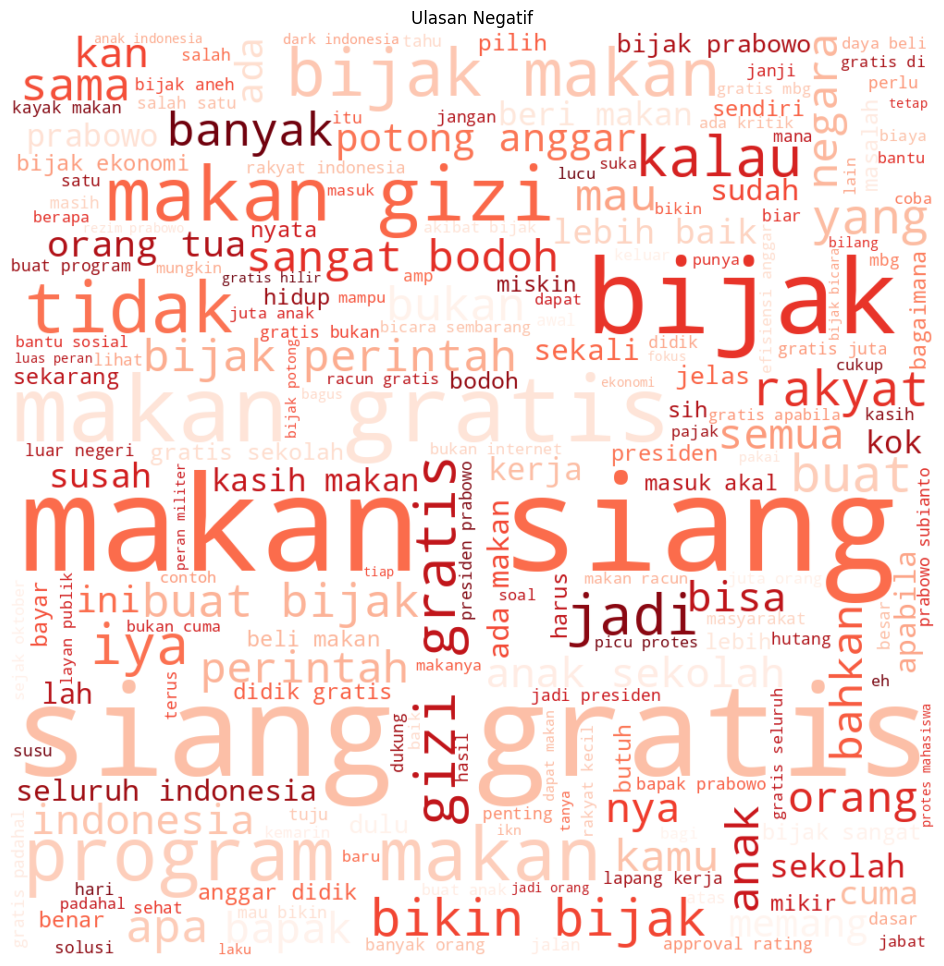

In [19]:
all_text_s0 = ' '.join(word for word in train_s0["full_text"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ulasan Negatif")
plt.margins(x=0, y=0)
plt.show()

In [20]:
train_s1 = result[result["Label"] == 1]
train_s1["full_text"] = train_s1["full_text"].fillna("Tidak ada komentar")

/tmp/ipython-input-3823219861.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_s1["full_text"] = train_s1["full_text"].fillna("Tidak ada komentar")


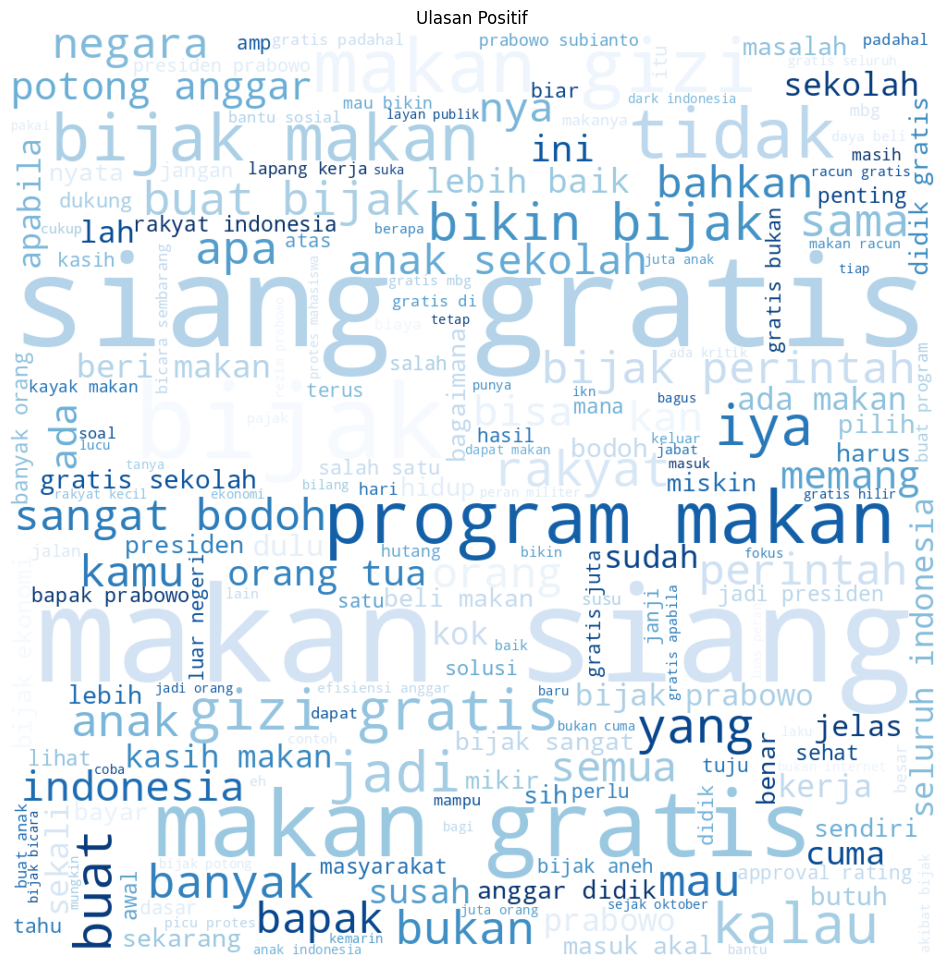

In [21]:
all_text_s1 = ' '.join(word for word in train_s1["full_text"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ulasan Positif")
plt.margins(x=0, y=0)
plt.show()

In [22]:
train_s2 = result[result["Label"] == 2]
train_s2["full_text"] = train_s2["full_text"].fillna("Tidak ada komentar")

/tmp/ipython-input-2147585198.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_s2["full_text"] = train_s2["full_text"].fillna("Tidak ada komentar")


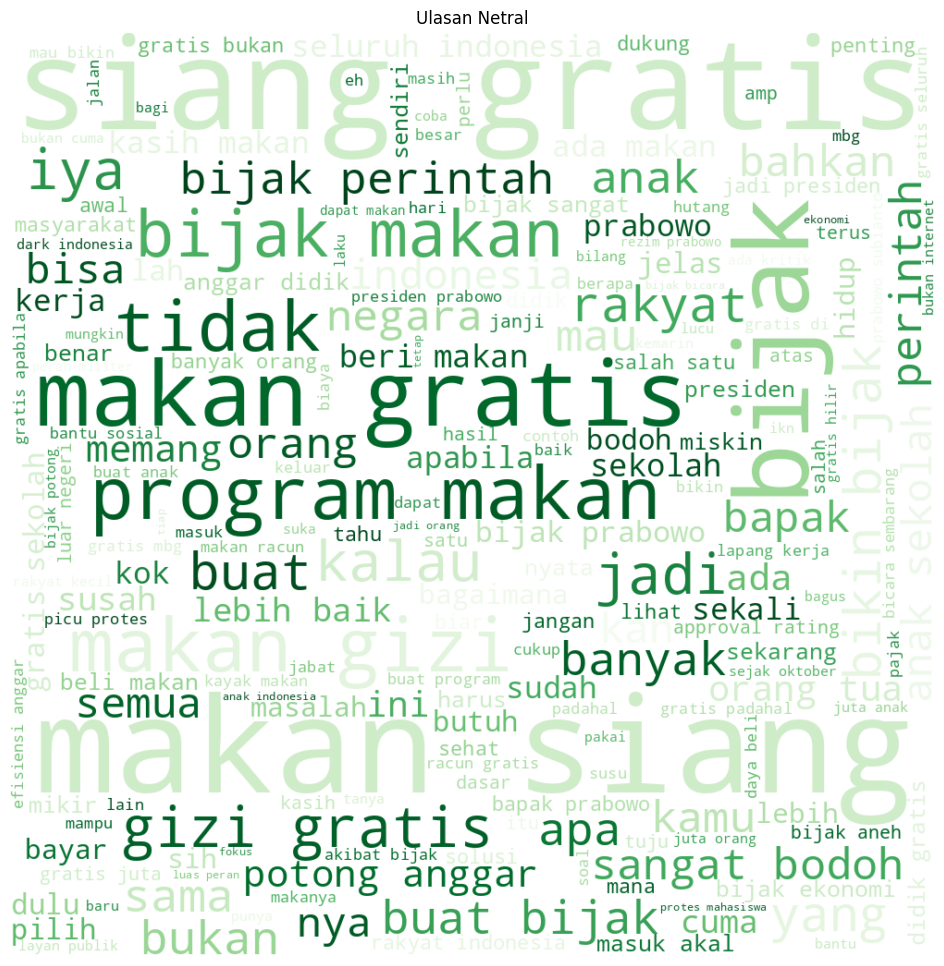

In [23]:
all_text_s2 = ' '.join(word for word in train_s2["full_text"])
wordcloud = WordCloud(colormap='Greens', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Ulasan Netral")
plt.margins(x=0, y=0)
plt.show()

## custom dataset


In [24]:
# Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['full_text']
        self.labels = dataframe['Label']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])
        text = " ".join(text.split())

        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            return_token_type_ids=True
        )

        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'token_type_ids': inputs['token_type_ids'],
            'labels': int(self.labels.iloc[index])
        }

## split data

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import BertTokenizer

# --- CONFIG ---
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
MAX_LEN = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10

# === Split Train & Validation 80/20 ===
train_df, val_df = train_test_split(
    result,
    test_size=0.2,         # 20% untuk validasi
    random_state=42,
    stratify=result['Label']  # menjaga proporsi label seimbang
)

# === Buat Dataset ===
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

# === Buat DataLoader ===
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples : {len(train_dataset)}")
print(f"Valid samples : {len(valid_dataset)}")


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Train samples : 5131
Valid samples : 1283


## set dataloader

In [26]:
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

# --- DATASET & DATALOADER ---
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
val_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,           # tetap shuffle untuk training
    collate_fn=data_collator
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,          # tidak perlu shuffle untuk validasi
    collate_fn=data_collator
)


## set model dan parameter training

In [27]:
# --- MODEL & OPTIMIZER & SCHEDULER ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p2", num_labels=3,  hidden_dropout_prob=0.3)
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

num_training_steps = NUM_EPOCHS * len(train_dataloader)

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## training

In [28]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Pastikan semua tensor sudah di device yang benar
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(**batch)
            logits = outputs.logits

            preds = torch.argmax(logits, dim=1)  # langsung argmax tanpa softmax

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, f1


In [29]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

best_f1 = 0
best_epoch = 0

train_losses, val_losses, val_accuracies, val_f1s = [], [], [], []

total_steps = NUM_EPOCHS * len(train_dataloader)
progress_bar = tqdm(total=total_steps, desc="Training")

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        batch = {
            k: (torch.tensor(v).to(device) if not isinstance(v, torch.Tensor) else v.to(device))
            for k, v in batch.items()
        }

        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'epoch': epoch + 1, 'loss': loss.item()})
        progress_bar.update(1)

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    val_acc = (torch.tensor(all_preds) == torch.tensor(all_labels)).float().mean().item()
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} — "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Accuracy: {val_acc:.4f} | F1 Score: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pt")

progress_bar.close()
print(f"\nTraining selesai. Best F1: {best_f1:.4f} pada epoch {best_epoch+1}")


Training:   0%|          | 3/1610 [00:01<09:44,  2.75it/s, epoch=1, loss=1.15]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Training:  10%|█         | 161/1610 [00:48<05:50,  4.13it/s, epoch=1, loss=0.192]


Epoch 1/10 — Train Loss: 0.6391 | Val Loss: 0.3947 | Val Accuracy: 0.8472 | F1 Score: 0.8481


Training:  20%|██        | 322/1610 [01:47<05:17,  4.06it/s, epoch=2, loss=0.388]


Epoch 2/10 — Train Loss: 0.3336 | Val Loss: 0.2601 | Val Accuracy: 0.9065 | F1 Score: 0.9061


Training:  30%|███       | 483/1610 [02:39<04:30,  4.17it/s, epoch=3, loss=0.537]


Epoch 3/10 — Train Loss: 0.1932 | Val Loss: 0.2199 | Val Accuracy: 0.9275 | F1 Score: 0.9280


Training:  40%|████      | 644/1610 [03:36<03:56,  4.09it/s, epoch=4, loss=0.00647]


Epoch 4/10 — Train Loss: 0.1221 | Val Loss: 0.1951 | Val Accuracy: 0.9384 | F1 Score: 0.9385


Training:  50%|█████     | 805/1610 [04:29<03:16,  4.10it/s, epoch=5, loss=0.0319]


Epoch 5/10 — Train Loss: 0.0837 | Val Loss: 0.1560 | Val Accuracy: 0.9556 | F1 Score: 0.9557


Training:  60%|██████    | 966/1610 [05:27<02:34,  4.16it/s, epoch=6, loss=0.00371]


Epoch 6/10 — Train Loss: 0.0638 | Val Loss: 0.1396 | Val Accuracy: 0.9602 | F1 Score: 0.9603


Training:  70%|███████   | 1127/1610 [06:19<01:59,  4.06it/s, epoch=7, loss=0.0181]


Epoch 7/10 — Train Loss: 0.0512 | Val Loss: 0.1552 | Val Accuracy: 0.9532 | F1 Score: 0.9533


Training:  80%|████████  | 1288/1610 [07:10<01:17,  4.15it/s, epoch=8, loss=0.0277]


Epoch 8/10 — Train Loss: 0.0371 | Val Loss: 0.1425 | Val Accuracy: 0.9618 | F1 Score: 0.9618


Training:  90%|█████████ | 1449/1610 [08:09<00:38,  4.17it/s, epoch=9, loss=0.0042]


Epoch 9/10 — Train Loss: 0.0338 | Val Loss: 0.1486 | Val Accuracy: 0.9571 | F1 Score: 0.9572


Training: 100%|██████████| 1610/1610 [09:03<00:00,  2.96it/s, epoch=10, loss=0.00389]


Epoch 10/10 — Train Loss: 0.0322 | Val Loss: 0.1472 | Val Accuracy: 0.9602 | F1 Score: 0.9603

Training selesai. Best F1: 0.9618 pada epoch 8


## visualisasi hasil training

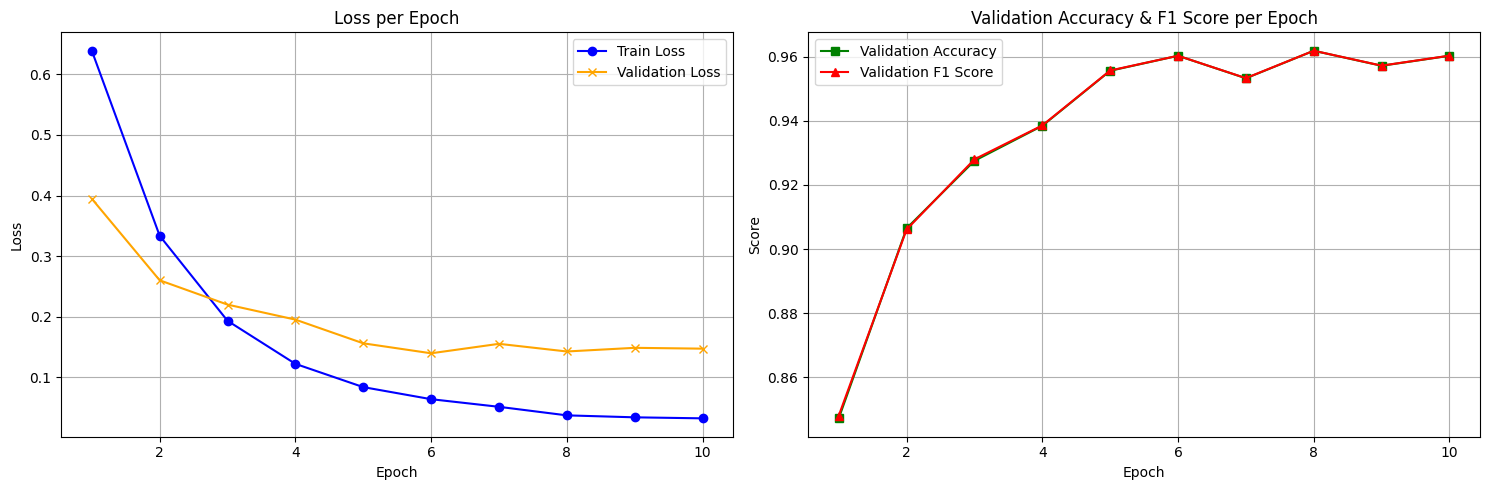

In [30]:
# Visualisasi hasil training
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(15, 5))

# Grafik Train Loss dan Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='blue', label='Train Loss')
plt.plot(epochs, val_losses, marker='x', color='orange', label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Grafik Validation Accuracy & F1 Score
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='s', color='green', label='Validation Accuracy')
plt.plot(epochs, val_f1s, marker='^', color='red', label='Validation F1 Score')
plt.title('Validation Accuracy & F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## confusion matriks


Validation Accuracy: 0.9618
Validation F1 Score (weighted): 0.9618

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       427
           1       0.95      0.96      0.96       428
           2       0.96      0.96      0.96       428

    accuracy                           0.96      1283
   macro avg       0.96      0.96      0.96      1283
weighted avg       0.96      0.96      0.96      1283



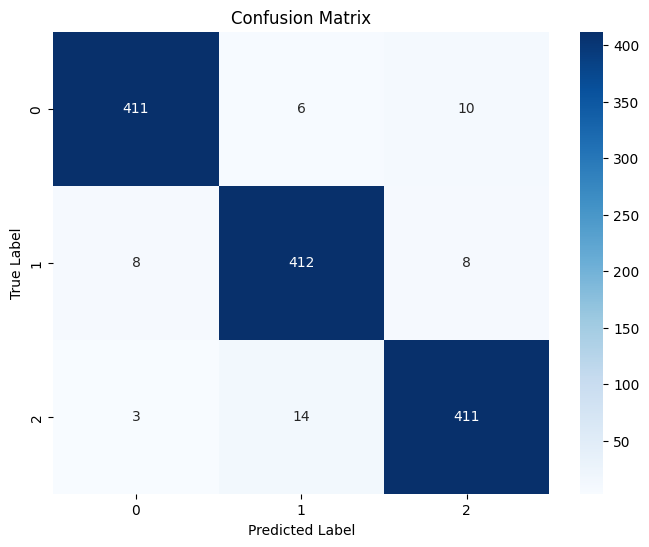

In [31]:
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Muat model terbaik
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Hitung metrik
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score (weighted): {f1:.4f}")

# Laporan klasifikasi per kelas
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix visualisasi
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## save model

In [32]:
import pickle

# Simpan keseluruhan model (bukan hanya state_dict) ke file .pkl
with open("best_model.pkl", "wb") as f:
    pickle.dump(model, f)


In [33]:
import torch
import pickle

MODEL_PATH = "/content/best_model.pkl"

# Load model di GPU dulu
with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

# Pindahkan model ke CPU
model.to(torch.device("cpu"))

# Simpan ulang model dalam format CPU
with open("/content/saved_2.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model berhasil disimpan ulang untuk CPU!")


✅ Model berhasil disimpan ulang untuk CPU!


In [35]:
import shutil

# Mount Google Drive (kalau belum)
from google.colab import drive
drive.mount('/content/drive')

# Salin file ke Drive
shutil.copy("/content/saved_2.pkl", "/content/drive/MyDrive/saved_model_dhini_3.pkl")

print("✅ Model berhasil disalin ke Google Drive")


Mounted at /content/drive
✅ Model berhasil disalin ke Google Drive


## test data baru pada model

In [37]:
import torch
import pickle
import pandas as pd
from transformers import BertTokenizer

# --- CONFIG ---
MODEL_PATH_CPU = "/content/drive/MyDrive/saved_model_dhini_3.pkl"
MAX_LEN = 128
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# === 1. Load model CPU ===
with open(MODEL_PATH_CPU, "rb") as f:
    model = pickle.load(f)

model.eval()  # mode evaluasi

# === 2. Siapkan 5 kalimat baru ===
new_sentences = [
    "Makan bergizi gratis? Serius emang kebijakan itu masih ada kah? Soalnya anakÂ² sekolah disini disuruh bawa omprengan kosong pas besoknya udah bawa katanya ga jadi makan siang gratisnya dan sampe sekarang ga pernah ada tuh yang n",
    "Kebijakan makan bergizi gratis dari Presiden Prabowo bukan hanya soal makanan tapi langkah awal menuju masa depan yang mandiri https://t.co/r2iUvFVYyj",
    "Boss mana nih lapangan pekerjaan makan siang yg bergizi dan sekolah gratis .. Janji kampanye tinggal janji yaaa boss.. Rakyat mu kecekik nih boss sama kebijakan anak buah lu..",
    "Ayok pak @prabowo Kapan bisa bikin kebijakan yg bisa bikin buka banyak peluang pekerjaan??? Ini ga bisa selesai dengan program makan siang gratis.. program gimmick semata yg malah buka peluang buat dikorupsi..",
    "Makan siang gratis di sekolah bukan hanya soal makanan, tapi juga pendidikan gizi dan kebiasaan sehat."
]


# === 3. Tokenisasi ===
encodings = tokenizer(
    new_sentences,
    add_special_tokens=True,
    max_length=MAX_LEN,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
)

# === 4. Prediksi ===
with torch.no_grad():
    outputs = model(
        input_ids=encodings['input_ids'],
        attention_mask=encodings['attention_mask'],
        token_type_ids=encodings['token_type_ids']
    )

# Jika model BERT + classifier: ambil argmax
predictions = torch.argmax(outputs.logits, dim=1).numpy()

# === 5. Tampilkan hasil ===
for sent, pred in zip(new_sentences, predictions):
    print(f"Kalimat : {sent}")
    print(f"Prediksi Label : {pred}")
    print("-" * 50)


Kalimat : Makan bergizi gratis? Serius emang kebijakan itu masih ada kah? Soalnya anakÂ² sekolah disini disuruh bawa omprengan kosong pas besoknya udah bawa katanya ga jadi makan siang gratisnya dan sampe sekarang ga pernah ada tuh yang n
Prediksi Label : 0
--------------------------------------------------
Kalimat : Kebijakan makan bergizi gratis dari Presiden Prabowo bukan hanya soal makanan tapi langkah awal menuju masa depan yang mandiri https://t.co/r2iUvFVYyj
Prediksi Label : 2
--------------------------------------------------
Kalimat : Boss mana nih lapangan pekerjaan makan siang yg bergizi dan sekolah gratis .. Janji kampanye tinggal janji yaaa boss.. Rakyat mu kecekik nih boss sama kebijakan anak buah lu..
Prediksi Label : 0
--------------------------------------------------
Kalimat : Ayok pak @prabowo Kapan bisa bikin kebijakan yg bisa bikin buka banyak peluang pekerjaan??? Ini ga bisa selesai dengan program makan siang gratis.. program gimmick semata yg malah buka peluang b